In [1]:
import os
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
from statistics import mean
import pickle
from sklearn.ensemble import RandomForestClassifier
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.utils.fixes import loguniform
import matplotlib.pyplot as plt
from sklearn.svm import SVC,NuSVC,LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold, RFE, SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
def shuffle(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p], p

def pca(data, gt, component, kernel=False, plot=False):
    if kernel==False:
        pca = PCA(n_components=component)
    elif kernel==True:
        pca = KernelPCA(n_components=None, 
                        kernel="rbf", 
                        gamma=10, 
                        fit_inverse_transform=True, 
                        alpha=0.1)

    feature = pca.fit_transform(data)
    if plot==True:
        plt.figure()
        sns.scatterplot(x=feature[:,0],
                        y=feature[:,1],
                        hue=gt,
                        palette=sns.color_palette(n_colors=len(np.unique(gt))))
    return feature

In [3]:
modelNuSVC= NuSVC(nu=0.7,kernel='rbf', gamma='auto',probability=True ,random_state=10)
modelSGD = SGDClassifier(loss='modified_huber',  penalty='l2', alpha=0.5,random_state= 10,fit_intercept=True,learning_rate='invscaling',eta0=0.01,power_t=0.1 )
modelMLP= MLPClassifier(hidden_layer_sizes=[200,1000],alpha=0.01,activation='relu',learning_rate='adaptive',solver='adam',max_iter=1000,random_state=10)
modelSVCsig= SVC(kernel="sigmoid", C=1.0, gamma='auto',probability=True,random_state=10)
modelSVCrbf= SVC(kernel="rbf", C=1.0, gamma='auto',probability=True,random_state=10)
modelSVClin= SVC(kernel="linear", C=1.0, gamma='auto',probability=True,random_state=10)

Estimators_all = [('NuSVC', modelNuSVC), ('MLP', modelMLP), ('SGD',modelSGD),('SVC', modelSVCsig), ('linsvc',LinearSVC(random_state=10))]
Estimators_svc= [('SVCrbf', modelSVCrbf), ('SVCsig', modelSVCsig), ('linsvc',modelSVClin)]
# modelSTACKsvc = StackingClassifier(estimators=Estimators_svc, final_estimator=modelMLP)
modelSTACKsvc = StackingClassifier(estimators=Estimators_svc, final_estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1.0))
modelADA = AdaBoostClassifier(random_state=50, base_estimator=modelSVCsig, n_estimators=100, learning_rate=0.0001, algorithm='SAMME.R')
modelBAG = BaggingClassifier(base_estimator=modelSVCrbf, n_estimators=150, bootstrap=False, bootstrap_features=True, random_state=50)

names=[
    "Linear SVM",
    "SIGMOID SVM",
    "RBF SVM",
    "Nu SVM",
    "Boosting with SVMrbf",
    "Bagging with SVMrbf",
    "Stack of SVMs",
    "Neural Net"
]

classifiers = [
    modelSVClin,
    modelSVCsig,
    modelSVCrbf,
    modelNuSVC,
    modelADA,
    modelBAG,
    modelSTACKsvc,
    modelMLP
]

In [4]:

model_scores={}
for name, clf in zip(names, classifiers):
    accuracynodel = []
    for fold in range(2,5):
        data_root = str('features/Fold_{:02d}/'.format(fold))
        # model_root = 'SavedModels/MachineLearning/'
        # if not os.path.exists(model_root):
        #     os.makedirs(model_root)
        #   
        TTS_train_feat = np.load(data_root+str('Train_features_TTS_fold_{:02d}.npy'.format(fold)))
        MI_train_feat = np.load(data_root+str('Train_features_MI_fold_{:02d}.npy'.format(fold)))
        TTS_test_feat = np.load(data_root+str('Test_features_TTS_fold_{:02d}.npy'.format(fold)))
        MI_test_feat = np.load(data_root+str('Test_features_MI_fold_{:02d}.npy'.format(fold)))
        
        X_train = np.concatenate((TTS_train_feat,MI_train_feat), axis=0)
        X_test = np.concatenate((TTS_test_feat,MI_test_feat), axis=0)
        y_train = np.concatenate((np.zeros((len(TTS_train_feat))),np.ones((len(MI_train_feat)))),axis=0)
        y_test = np.concatenate((np.zeros((len(TTS_test_feat))),np.ones((len(MI_test_feat)))),axis=0)
        
        X_train, y_train, p = shuffle(X_train, y_train)
        
        print('--------------')
        print(str('Fold-{:02d}'.format(fold)))
        print('--------------')

        X_train = np.reshape(X_train,(X_train.shape[0],-1))
        X_test = np.reshape(X_test,(X_test.shape[0],-1))
        print(X_train.shape, X_test.shape)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        print('Training start...')
        clf.fit(X_train, y_train)
        print(clf.score(X_test, y_test))
        accuracynodel.append(clf.score(X_test, y_test))
    print(f'\t 3-fold average accrucary:{mean(accuracynodel):.2f}')
    model_scores[name]= mean(accuracynodel)


--------------
Fold-02
--------------
(189, 3584) (63, 3584)
Training start...
0.7619047619047619
--------------
Fold-03
--------------
(189, 3584) (63, 3584)
Training start...
0.7777777777777778
--------------
Fold-04
--------------
(190, 3584) (62, 3584)
Training start...
0.7580645161290323
	 3-fold average accrucary:0.77
--------------
Fold-02
--------------
(189, 3584) (63, 3584)
Training start...
0.7619047619047619
--------------
Fold-03
--------------
(189, 3584) (63, 3584)
Training start...
0.7936507936507936
--------------
Fold-04
--------------
(190, 3584) (62, 3584)
Training start...
0.7903225806451613
	 3-fold average accrucary:0.78
--------------
Fold-02
--------------
(189, 3584) (63, 3584)
Training start...
0.7619047619047619
--------------
Fold-03
--------------
(189, 3584) (63, 3584)
Training start...
0.7936507936507936
--------------
Fold-04
--------------
(190, 3584) (62, 3584)
Training start...
0.7903225806451613
	 3-fold average accrucary:0.78
--------------
Fold-02

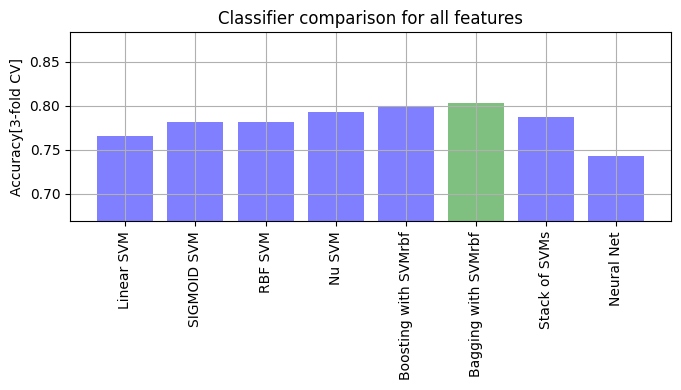

In [5]:

model_scores['Neural Net']= 0.743
SCORE_feature_3=[]
for value in model_scores.values():
    SCORE_feature_3.append(round(value,3))

x_pos = np.arange(len(names))


fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier comparison for all features")
ax.set_xticks(x_pos)
ax.set_xticklabels(names, rotation="vertical")
ax.set_ylabel("Accuracy[3-fold CV]")
ax.set_ylim([min(SCORE_feature_3) * 0.9, max(SCORE_feature_3) * 1.1])

colors= [None]*len(SCORE_feature_3)
for i in range(len(SCORE_feature_3)):
    if SCORE_feature_3[i]== max(SCORE_feature_3):
        colors[i]="g"
    else:
        colors[i]="b"

ax.bar(x_pos, SCORE_feature_3, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()